In [1]:
import bagpy
import seaborn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import bagpy


bag_file = "../bags/session1_2023-03-13-14-13-37.bag"

b = bagpy.bagreader(bag_file)

[INFO]  Data folder ../bags/session1_2023-03-13-14-13-37 already exists. Not creating.


In [3]:
clicked_point_csv = b.message_by_topic('clicked_point')
clicked_point_df = pd.read_csv(clicked_point_csv)
clicked_point_df

Time  header.seq  header.stamp.secs  header.stamp.nsecs header.frame_id  \
0  152.242          10                152           241000000           world   
1  154.162          11                154           162000000           world   
2  156.287          12                156           287000000           world   
3  159.549          13                159           538000000           world   
4  161.359          14                161           359000000           world   

    point.x   point.y   point.z  
0  2.267237  2.269677  0.005716  
1  2.252634 -2.196055  0.005661  
2 -2.162921 -2.129572  0.003009  
3 -2.193344  2.276760  0.002795  
4  0.372460  1.346252  0.006276

In [4]:
exploration_start_time = clicked_point_df.iloc[-1]['Time']

point1 = np.array([clicked_point_df.iloc[0]['point.x'], clicked_point_df.iloc[0]['point.y']])
point2 = np.array([clicked_point_df.iloc[2]['point.x'], clicked_point_df.iloc[2]['point.y']])

exploration_width = abs(point1[0] - point2[0])
exploration_height = abs(point1[1] - point2[1])
exploration_area = exploration_width * exploration_height

exploration_width, exploration_height, exploration_area

(4.4301581382751465, 4.399249076843262, 19.4893691000766)

In [5]:
world_map_csv = b.message_by_topic('map')
world_map_df = pd.read_csv(world_map_csv)
world_map_df = world_map_df.loc[(world_map_df['Time'] > exploration_start_time)]
world_map_df.shape

(134, 37266)

In [6]:
diff_width = world_map_df.iloc[0]['info.width'] - world_map_df.iloc[-1]['info.width']
diff_height = world_map_df.iloc[0]['info.height'] - world_map_df.iloc[-1]['info.height']
diff_width, diff_height

(0, 0)

In [7]:
world_map_width, world_map_height = world_map_df.iloc[0]['info.width'], world_map_df.iloc[0]['info.height']
world_map_data = world_map_df.filter(like="data_", axis=1).to_numpy()
world_map_data = np.resize(world_map_data, (world_map_df.shape[0], world_map_height, world_map_width))
world_map_data.shape

(134, 193, 193)

In [8]:
def point_to_index(map_origins, map_resolution, map_dimensions, point):
    origin_x, origin_y = map_origins
    width, height = map_dimensions

    x, y = point[0], point[1]

    index_x = int(round((x - origin_x) / map_resolution))
    index_y = int(round((y - origin_y) / map_resolution))

    index_x = index_x if index_x < width else width - 1
    index_y = index_y if index_y < height else height - 1

    return [index_x, index_y]

def index_to_point(map_origins, map_resolution, index):
    origin_x, origin_y = map_origins

    index_x, index_y = index[0], index[1]

    x = origin_x + index_x * map_resolution
    y = origin_y + index_y * map_resolution

    return np.array([x, y])

In [9]:
def count_cells(corners, map_data, map_origins, map_resolution, map_dimensions):
    x, y = map_origins
    corner1, corner2 = corners
    
    corner1_index = point_to_index(map_origins, map_resolution, map_dimensions, corner1)
    corner2_index = point_to_index(map_origins, map_resolution, map_dimensions, corner2)
    
    exploration_data = map_data[corner1_index[1]:corner2_index[1] + 1, corner1_index[0]:corner2_index[0] + 1]
    unique, counts = np.unique(exploration_data, return_counts=True)
    d = dict(zip(unique, counts))
    return d

count_cells(
    [point2, point1], 
    world_map_data[0], 
    [world_map_df.iloc[0]['info.origin.position.x'],  world_map_df.iloc[0]['info.origin.position.y']],
    world_map_df.iloc[0]['info.resolution'],
    [world_map_width, world_map_height]
)

{-1: 2931, 0: 4853, 100: 137}

In [10]:
corners = [point2, point1]
world_map_origins = [world_map_df.iloc[0]['info.origin.position.x'],  world_map_df.iloc[0]['info.origin.position.y']]
world_map_resolution = world_map_df.iloc[0]['info.resolution']
world_map_dimensions = [world_map_width, world_map_height]

In [11]:
unknown_cells = [
    count_cells(corners, world_map_data[i], world_map_origins, world_map_resolution, world_map_dimensions)[-1]
    for i in range(world_map_data.shape[0])
]

In [12]:
unknown_area = [
    c * (world_map_resolution ** 2)
    for c in unknown_cells
]

In [13]:
unknown_area_percentage = [
    c / exploration_area * 100
    for c in unknown_area
]

In [14]:
world_map_df['Time'] = world_map_df['Time'] - exploration_start_time
world_map_df['Unknown area percentage'] = unknown_area_percentage
world_map_df

Time  header.seq  header.stamp.secs  header.stamp.nsecs  \
24     0.233         162                161           590000000   
25     1.124         163                162           481000000   
26     2.214         164                163           572000000   
27     3.161         165                164           518000000   
28     4.266         166                165           623000000   
..       ...         ...                ...                 ...   
153  129.198         291                290           555000000   
154  130.214         292                291           571000000   
155  131.209         293                292           567000000   
156  132.199         294                293           555000000   
157  133.196         295                294           554000000   

    header.frame_id  info.map_load_time.secs  info.map_load_time.nsecs  \
24            world                      161                 590000000   
25            world                      162                 481000000   
26            world                      163                 572000000   
27            world                      164                 518000000   
28            world                      165                 623000000   
..              ...                      ...                       ...   
153           world                      290                 555000000   
154           world                      291                 571000000   
155           world                      292                 567000000   
156           world                      293                 555000000   
157           world                      294                 554000000   

     info.resolution  info.width  info.height  ...  data_37240  data_37241  \
24              0.05         193          193  ...          -1          -1   
25              0.05         193          193  ...          -1          -1   
26              0.05         193          193  ...          -1          -1   
27              0.05         193          193  ...          -1          -1   
28              0.05         193          193  ...          -1          -1   
..               ...         ...          ...  ...         ...         ...   
153             0.05         193          193  ...          -1          -1   
154             0.05         193          193  ...          -1          -1   
155             0.05         193          193  ...          -1          -1   
156             0.05         193          193  ...          -1          -1   
157             0.05         193          193  ...          -1          -1   

     data_37242  data_37243  data_37244  data_37245  data_37246  data_37247  \
24           -1          -1          -1          -1          -1          -1   
25           -1          -1          -1          -1          -1          -1   
26           -1          -1          -1          -1          -1          -1   
27           -1          -1          -1          -1          -1          -1   
28           -1          -1          -1          -1          -1          -1   
..          ...         ...         ...         ...         ...         ...   
153          -1          -1          -1          -1          -1          -1   
154          -1          -1          -1          -1          -1          -1   
155          -1          -1          -1          -1          -1          -1   
156          -1          -1          -1          -1          -1          -1   
157          -1          -1          -1          -1          -1          -1   

     data_37248  Unknown area percentage  
24           -1                37.597421  
25           -1                37.597421  
26           -1                37.597421  
27           -1                37.597421  
28           -1                37.597421  
..          ...                      ...  
153          -1                 1.641921  
154          -1                 1.641921  
155          -1                 1.641921 

<Axes: xlabel='Time', ylabel='Unknown area percentage'>

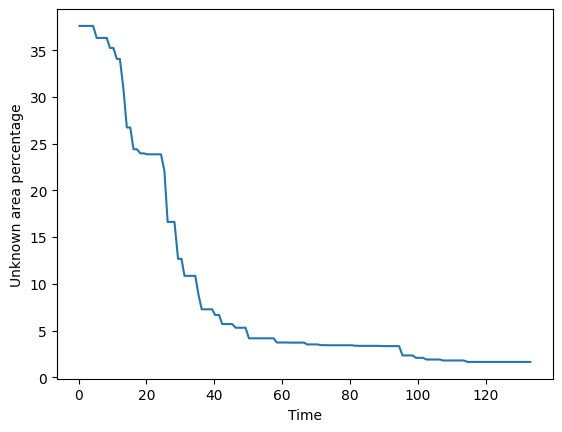

In [15]:
seaborn.lineplot(data=world_map_df, x='Time', y='Unknown area percentage')